WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


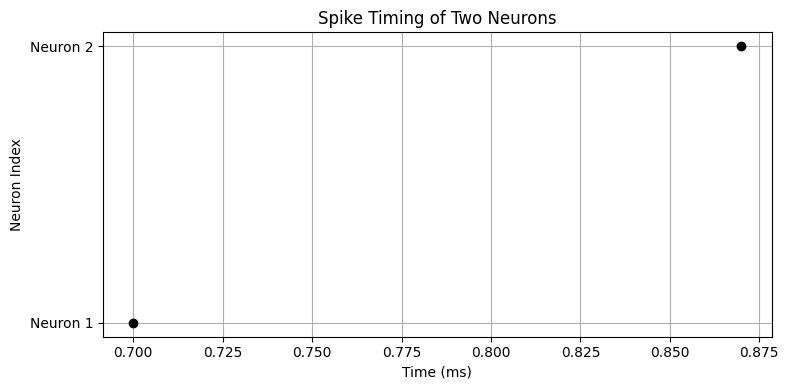

In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Setup
start_scope()
defaultclock.dt = 0.01*ms

# Parameters
input_value = 0.7  # value to encode as time offset (0.0–1.0)
input_time = input_value * ms
weight = 8.0  # sigmoid weight control
duration = 3*ms

# Sigmoid timing transformation
def transform_time(t, w):
    return 1.0 / (1.0 + np.exp(w * (t - 0.5)))

# Input spike
input_indices = [0]
input_times = [input_time]
input_group = SpikeGeneratorGroup(1, input_indices, input_times*second)

# Neuron model (dummy, spikes manually triggered)
G = NeuronGroup(2, 'v:1', threshold='v>1', reset='v=0', method='exact')

# Record spikes
spike_mon = SpikeMonitor(G)

stimulated = False  # outside network_operation

@network_operation(dt=0.01*ms)
def stimulate_first():
    global stimulated
    if not stimulated and defaultclock.t >= input_time:
        G.v[0] = 1.1
        stimulated = True

# Schedule second neuron to spike after sigmoid transform
has_spiked = False

@network_operation(dt=0.01*ms)
def transformed_spike():
    global has_spiked
    if not has_spiked and len(spike_mon.t) > 0:
        t_spike_1 = spike_mon.t[0]/ms  # Neuron 0 spike time
        # Apply timing transform
        delay = transform_time(t_spike_1 / 1.0, weight) * ms
        t_spike_2 = t_spike_1 * ms + delay
        if defaultclock.t >= t_spike_2:
            G.v[1] = 1.1
            has_spiked = True

run(duration)

# Plot
plt.figure(figsize=(8, 4))
plt.title("Spike Timing of Two Neurons")
plt.plot(spike_mon.t/ms, spike_mon.i, 'ko')
plt.yticks([0, 1], ['Neuron 1', 'Neuron 2'])
plt.xlabel("Time (ms)")
plt.ylabel("Neuron Index")
plt.grid(True)
plt.tight_layout()
plt.show()


SyntaxError: unterminated triple-quoted string literal (detected at line 114) (3012090721.py, line 45)

Input spike times: [0.]
Transformed delay (ms): 0.9990889488055994
Output spike times: []


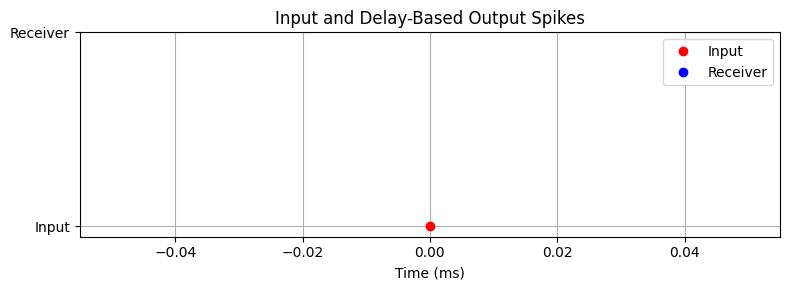

In [33]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

start_scope()
defaultclock.dt = 0.01*ms     

# Parameters
starting_val = 0.7       # Delay input
weight_1 = 10.0           # Sigmoid weight
base_spike_time = 1.0*ms
runtime = 5*ms

# Define neuron model with sigmoid transformation
eqs = '''
delta : 1
w : 1
incoming_spike : second  # Stores spike time when input is received
spike_scheduled : boolean  # Tracks if we've scheduled spike yet
output = (1.0 / (1.0 + exp(-w * delta))) * ms : second
spike_triggered : boolean
'''

# INPUT 
input_times = [base_spike_time]  # single spike
input_indices = [0]
input_group = SpikeGeneratorGroup(1, input_indices, input_times*ms)

# RECEIVER
receiver = NeuronGroup(1, eqs,
                       threshold='spike_triggered',
                       reset='spike_triggered = False',
                       method='euler')

receiver.delta = starting_val
receiver.w = weight_1
receiver.spike_triggered = False
receiver.spike_scheduled = False
receiver.incoming_spike = 0*ms

# Synapse: record when the input spike arrives
syn = Synapses(input_group, receiver, 
               on_pre='''
               incoming_spike = t
               spike_scheduled = False
               ''')
syn.connect()

# Timing logic: wait until after input arrives, then trigger at correct delay
@network_operation(dt=defaultclock.dt)
def timing_logic():
    if not receiver.spike_triggered and not receiver.spike_scheduled:
        delay = receiver.output[0]
        target_time = receiver.incoming_spike[0] + delay
        if defaultclock.t >= target_time:
            receiver.spike_triggered = True
            receiver.spike_scheduled = True

# Monitors
mon_input = SpikeMonitor(input_group)
mon_output = SpikeMonitor(receiver)

# Run simulation
run(runtime)

# Output
print("Input spike times:", mon_input.t/ms)
print("Transformed delay (ms):", receiver.output[0]/ms)
print("Output spike times:", mon_output.t/ms)

# Plot
plt.figure(figsize=(8, 3))
plt.plot(mon_input.t/ms, [0]*len(mon_input.t), 'ro', label='Input')
plt.plot(mon_output.t/ms, [1]*len(mon_output.t), 'bo', label='Receiver')
plt.yticks([0, 1], ['Input', 'Receiver'])
plt.xlabel('Time (ms)')
plt.title('Input and Delay-Based Output Spikes')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


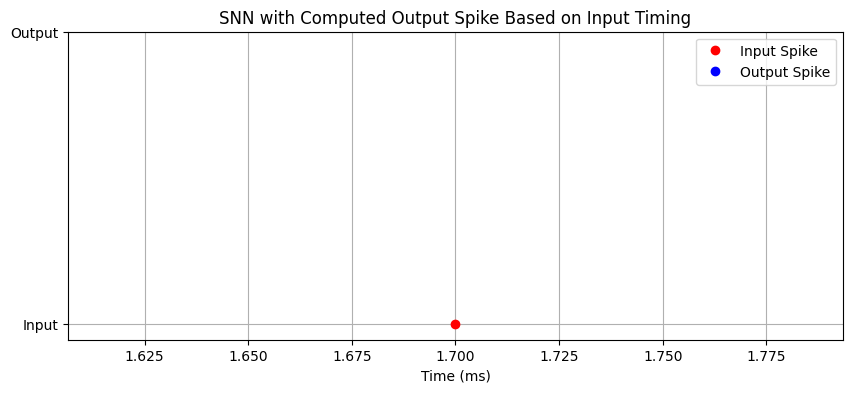

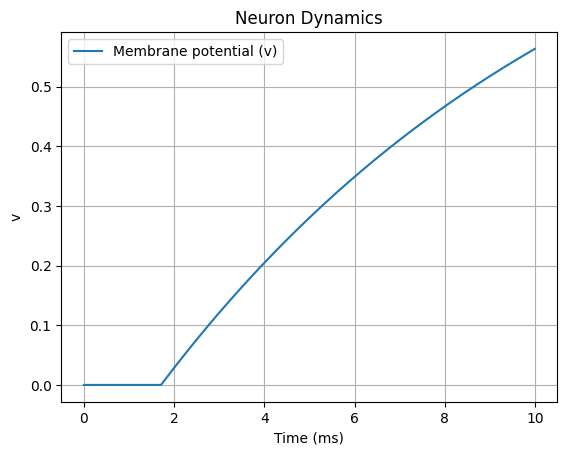

In [3]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

start_scope()
defaultclock.dt = 0.01*ms

# Parameters
input_value = 0.7  # Encoded as time delay (in ms)

duration = 10*ms
weight = 6.0

# Neuron model: LIF with exponential decay input current
eqs = '''
dv/dt = (I - v) / (10*ms) : 1
I : 1
'''

# Input spike at t=1.0 ms + input_value
input_times = [(0, 1.0 + input_value)*ms]
input_group = SpikeGeneratorGroup(1, [0,0], [0.0, (1.0 + input_value)*ms])

# Neuron group
neurons = NeuronGroup(1, eqs, threshold='v > 1', reset='v = 0', method='linear')
neurons.I = 0  # will be set via synapse

# Synapse encodes weight using timing delay
syn = Synapses(input_group, neurons, on_pre='I += 1.0')
syn.connect()

# Monitors
spike_mon_in = SpikeMonitor(input_group)
spike_mon_out = SpikeMonitor(neurons)
state_mon = StateMonitor(neurons, ['v', 'I'], record=True)

# Run simulation
run(duration)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(spike_mon_in.t/ms, [0]*len(spike_mon_in.t), 'ro', label='Input Spike')
plt.plot(spike_mon_out.t/ms, [1]*len(spike_mon_out.t), 'bo', label='Output Spike')
plt.yticks([0, 1], ['Input', 'Output'])
plt.xlabel("Time (ms)")
plt.title("SNN with Computed Output Spike Based on Input Timing")
plt.grid(True)
plt.legend()
plt.show()




0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms
0.7 ms
0.34073961 ms


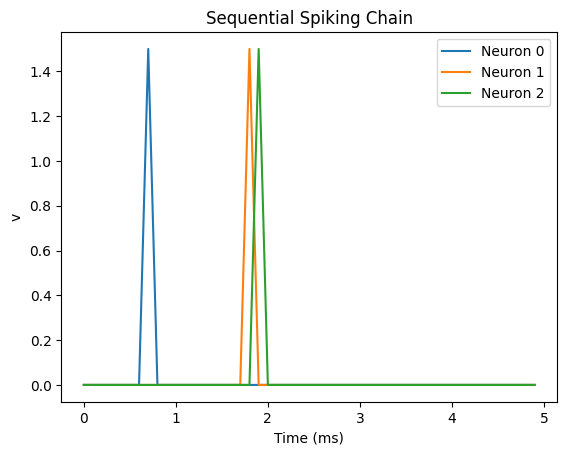

Input spike times: [0.6] ms
Neuron 0 spikes: [0.7] ms
Neuron 1 spikes: [1.8] ms
Neuron 2 spikes: [1.9] ms


In [80]:
from brian2 import *

start_scope()

# Neuron model (LIF with decay)
eqs = '''
dv/dt = -v/tau : 1  # not important will change so just instantinous spikes
tau : second
'''


initial_input = 0.6   # not a .1 delay for all tranfers
base_delay = 0.9*ms # because of addational .1 added for spike transfer

G = NeuronGroup(3, eqs, threshold='v > 1', reset='v = 0', method='exact')
G.tau = 10*ms
G.v = 0

input = SpikeGeneratorGroup(1, [0], [initial_input*ms])
input_syn = Synapses(input, G, on_pre='v_post += 1.5')
input_syn.connect(i=0, j=0)
#input_syn.delay = 0*ms  # delay from input to neuron 0


#sigmoid_delay = '(0.5 + 1 / (1 + exp(-5 * (t_pre - 0.7 * ms)))) * ms'
#@network_operation
def sig_delay(w, t_in, layer):
    '''weight = w, t_in is the spike_time, layer is to reduce added time'''
    return (1/ (1 + np.exp(-w*(t_in-layer)))) 

#print(sig_delay(2.2, 1.5, 1))

# Neuron 0 → Neuron 1
w1 = 2.2

S1 = Synapses(G, G, on_pre='v_post += 1.5')
S1.connect(i=0, j=1)
# Use the sigmoid function to set the delay dynamically
S1.delay = "1 * ms"   # Example delay function



# Neuron 1 → Neuron 2
w2 = -5.1
S2 = Synapses(G, G, on_pre='v_post += 1.5')
S2.connect(i=1, j=2)

# Monitor voltage
M = StateMonitor(G, 'v', record=True)
spike_mon = SpikeMonitor(G)
input_mon = SpikeMonitor(input)

var = -1



@network_operation
def update_delay():
    # Update delays in first synapse group (S1) with layer=1
    for i, j in zip(S1.i[:], S1.j[:] ):
        spikes = spike_mon.spike_trains()[i]
        if len(spikes) > 0:
            last_spike_time = spikes[-1]
            print(last_spike_time)
            delay_val = sig_delay(w1, last_spike_time / ms, layer=1) * ms
            print(delay_val)
            S1.delay[i, j] = delay_val + 4 * ms 

    # Update delays in second synapse group (S2) with layer=2
    for i, j in zip(S2.i[:], S2.j[:] ):
        spikes = spike_mon.spike_trains()[i]
        if len(spikes) > 0:
            last_spike_time = spikes[-1]
            delay_val = sig_delay(w2, last_spike_time / ms, layer=2) * ms
            S2.delay[i, j] = delay_val




run(5*ms)

#print(var)





# Plot voltage traces
plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
title('Sequential Spiking Chain')
legend()
show()

# Spike time printout
print("Input spike times:", input_mon.spike_trains()[0])
for i in range(3):
    print(f"Neuron {i} spikes: {spike_mon.spike_trains()[i]}")



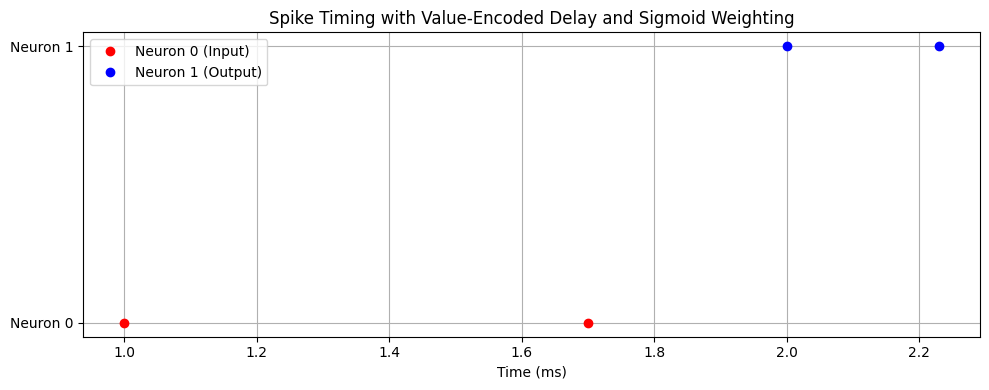

In [14]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

# Setup
start_scope()
defaultclock.dt = 0.01*ms

# Parameters
input_value = 0.7  # delay from start spike (in ms)
weight = 6.0       # sigmoid weight
duration = 5*ms

# Sigmoid function to compress value timing
def transform_delay(delta, w):
    return 1.0 / (1.0 + np.exp(w * (delta - 0.5)))

# Transformed output delay
delta_out = transform_delay(input_value, weight)

# Input spike times: start at 1.0 ms, value spike at 1.0 + input_value
input_times = [1.0, 1.0 + input_value]*ms
input_indices = [0, 0]
input_group = SpikeGeneratorGroup(1, input_indices, input_times)

# Output spike times: start at 2.0 ms, value spike at 2.0 + delta_out
output_times = [2.0, 2.0 + delta_out]*ms
output_indices = [0, 0]
output_group = SpikeGeneratorGroup(1, output_indices, output_times)

# Spike monitors
mon_input = SpikeMonitor(input_group)
mon_output = SpikeMonitor(output_group)

# Run the network
run(duration)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(mon_input.t/ms, [0]*len(mon_input.t), 'ro', label='Neuron 0 (Input)')
plt.plot(mon_output.t/ms, [1]*len(mon_output.t), 'bo', label='Neuron 1 (Output)')
plt.yticks([0, 1], ['Neuron 0', 'Neuron 1'])
plt.xlabel("Time (ms)")
plt.title("Spike Timing with Value-Encoded Delay and Sigmoid Weighting")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Epoch 0, Loss: 0.04565755125219266, Weight: 7.006713282713304
Epoch 10, Loss: 0.046300699602308606, Weight: 7.073804744301407
Epoch 20, Loss: 0.04694227909970238, Weight: 7.140813522208131
Epoch 30, Loss: 0.047582090879889405, Weight: 7.207729135609323
Epoch 40, Loss: 0.0482199418107156, Weight: 7.274541360794114
Epoch 50, Loss: 0.048855644648960854, Weight: 7.34124023611143
Epoch 60, Loss: 0.04948901817573123, Weight: 7.407816066238443
Epoch 70, Loss: 0.050119887311062795, Weight: 7.474259425786046
Epoch 80, Loss: 0.05074808320824457, Weight: 7.54056116225845
Epoch 90, Loss: 0.05137344332844506, Weight: 7.6067123983858815
Final weight after training: 7.666112719200649


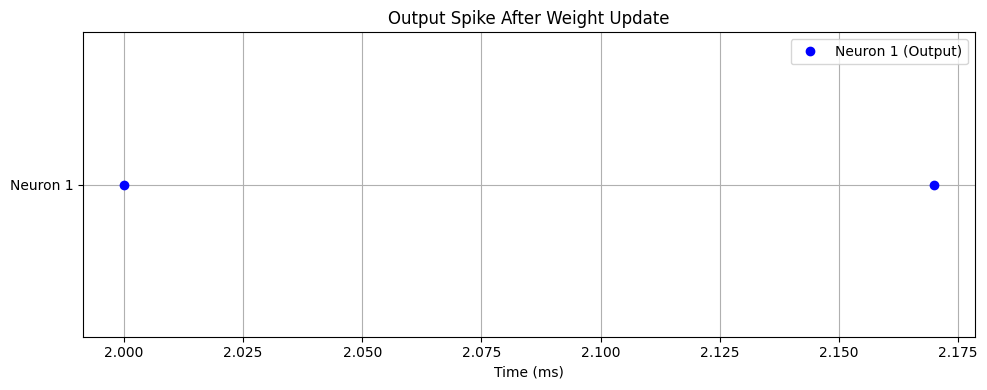

In [10]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

# Setup
start_scope()
defaultclock.dt = 0.01*ms

# Parameters
input_value = 0.7  # delay from start spike (in ms)
initial_weight = 7.0  # initial weight
learning_rate = 0.2  # learning rate for gradient descent
duration = 5*ms

# Sigmoid function to compress value timing
def transform_delay(delta, w):
    return 1.0 / (1.0 + np.exp(w * (delta - 0.5)))

# Loss function (Mean Squared Error)
def loss_function(true_value, predicted_value):
    return 0.5 * (true_value - predicted_value)**2

# Gradient of the loss function with respect to the weight
def compute_gradients(true_value, predicted_value, input_value, weight):
    # Compute the derivative of the sigmoid with respect to the weight
    sigmoid_derivative = np.exp(weight * (input_value - 0.5)) / (1 + np.exp(weight * (input_value - 0.5)))**2
    error = predicted_value - true_value
    # Gradient of the loss with respect to weight (simplified)
    gradient = error * sigmoid_derivative * input_value  # Propagate error through sigmoid and timing
    return gradient

# Initial weight
weight = initial_weight

# Simulate the forward pass and calculate the output
def simulate_forward_pass(input_value, weight):
    delta_out = transform_delay(input_value, weight)
    # Simulate the spikes (start spike at 2ms, value spike at 2ms + delta_out)
    return delta_out

# Training loop
epochs = 100
for epoch in range(epochs):
    # Forward pass to get predicted output
    predicted_value = simulate_forward_pass(input_value, weight)
    
    # Compute the true value we want to compare against
    true_value = 0.5  # This is the desired output spike time (for example)
    
    # Calculate the loss
    loss = loss_function(true_value, predicted_value)
    
    # Compute the gradient of the loss with respect to the weight
    gradient = compute_gradients(true_value, predicted_value, input_value, weight)
    
    # Update the weight using gradient descent
    weight -= learning_rate * gradient
    
    # Optionally print loss to track progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss}, Weight: {weight}")

# Final weight after training
print(f"Final weight after training: {weight}")

# Plotting (for visualization)
plt.figure(figsize=(10, 4))

# Final simulation after training
final_delta_out = simulate_forward_pass(input_value, weight)
final_output_times = [2.0, 2.0 + final_delta_out] * ms
output_indices = [0, 0]
output_group = SpikeGeneratorGroup(1, output_indices, final_output_times)

# Spike monitor
mon_output = SpikeMonitor(output_group)

# Run the network after training
run(duration)

# Plot spikes
plt.plot(mon_output.t/ms, [1]*len(mon_output.t), 'bo', label='Neuron 1 (Output)')
plt.yticks([1], ['Neuron 1'])
plt.xlabel("Time (ms)")
plt.title("Output Spike After Weight Update")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
    

In [16]:
print(random(1)[0])

0.6576207697412544
